In [9]:
###############################################################################
############### Term Project - Dog & Cat Classification #######################
######################### Author - Siyuan Liu #################################
########################### March 2022 ########################################

In [10]:
#https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

In [11]:
# Helper libraries
import os 
import numpy as np
import tensorflow as tf
import time
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import re # regular expressions
import scipy
import os # Operation System
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
import tensorflow as tf
from datetime import datetime
import cv2
import seaborn as sns


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
#from plot_keras_history import plot_history

In [12]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [13]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)


This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [14]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [15]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Load the data

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
import zipfile
train_file = "/content/gdrive/MyDrive/458_AI/A4/train.zip"
with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

test_file = "/content/gdrive/MyDrive/458_AI/A4/test.zip"
with zipfile.ZipFile(test_file, 'r') as z:
    z.extractall()

z.close()

In [18]:
base_dir = "/content"
train_dir = os.path.join(base_dir, 'train')
train_img_names = os.listdir(train_dir)

test_dir = os.path.join(base_dir, 'test') 
test_img_names = os.listdir(test_dir)

In [19]:
train_img_names[:10]

['cat.10613.jpg',
 'cat.7065.jpg',
 'dog.4677.jpg',
 'cat.2305.jpg',
 'cat.11144.jpg',
 'cat.4830.jpg',
 'dog.8646.jpg',
 'dog.4178.jpg',
 'dog.496.jpg',
 'dog.11782.jpg']

In [20]:
test_img_names[:10]

['11390.jpg',
 '4977.jpg',
 '7427.jpg',
 '5513.jpg',
 '3415.jpg',
 '12276.jpg',
 '4666.jpg',
 '3015.jpg',
 '4275.jpg',
 '11417.jpg']

In [21]:
print('total train images :', len(train_img_names ))
print('total test images :', len(test_img_names ))

total train images : 25000
total test images : 12500


In [22]:
# Sorting of file names facilitated by
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# Generate list of file names, excluding hidden files    
def directory_list (dir_name):
    start_list = os.listdir(dir_name)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file) 
    end_list.sort(key = alphanum_key)        
    return(end_list)    

train_ls = directory_list(train_dir)
len(train_ls)
test_ls = directory_list(test_dir)
len(test_ls)

12500

In [23]:
train_ls[0:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.4.jpg']

In [24]:
#split the file name and extract label data
labels = []
for image in train_ls:
    label = image.split(".")[0]
    if label == "dog":
        labels.append("dog")
    else:
        labels.append("cat")
df_train = pd.DataFrame({"Image":train_img_names, "label": labels})

In [25]:
df_train.head()

,Image,label
0,cat.10613.jpg,cat
1,cat.7065.jpg,cat
2,dog.4677.jpg,cat
3,cat.2305.jpg,cat
4,cat.11144.jpg,cat


#EDA

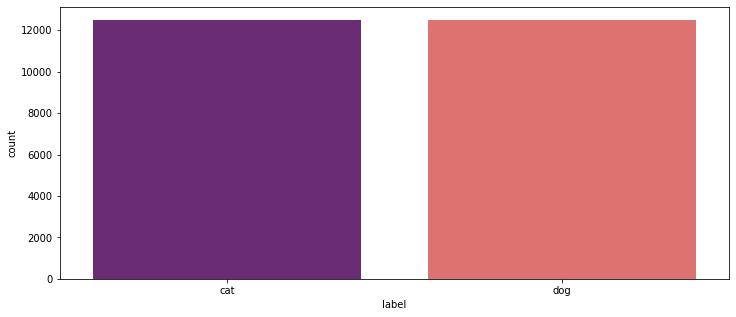

In [26]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_train, x="label",palette="magma") 

In [27]:
print(df_train['label'].value_counts())

cat    12500
dog    12500
Name: label, dtype: int64


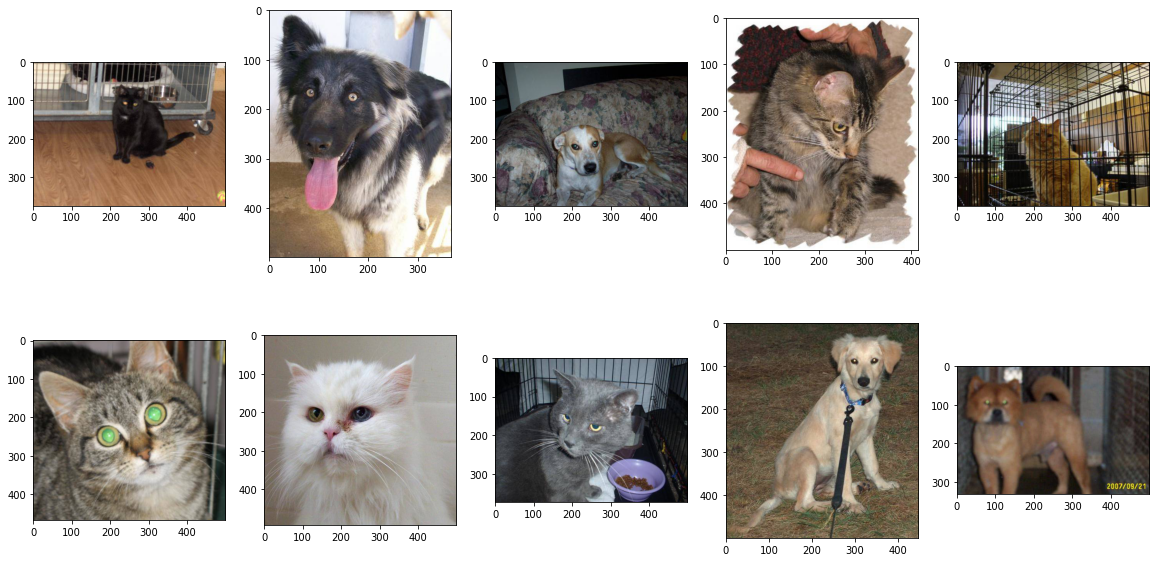

In [28]:
import random
ran_spl = random.choices(train_img_names, k=10)

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(plt.imread(("/content/train/"+ran_spl[i])))
plt.show()


In [29]:
ran_spl

['cat.9938.jpg',
 'dog.10301.jpg',
 'dog.2583.jpg',
 'cat.1279.jpg',
 'cat.1312.jpg',
 'cat.11160.jpg',
 'cat.1927.jpg',
 'cat.10383.jpg',
 'dog.10177.jpg',
 'dog.12431.jpg']

In [30]:
#image processing functions
def parse_grayscale(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    return(image)
    
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)
  
def parse_grayscale_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  
    
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

In [31]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [32]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [33]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [34]:
import errno
outdir = '/content/cats_dogs_arrays'
try:
    os.makedirs(outdir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [35]:
# Create Numpy Image Arrays
#----------------------------------------------------------------------
print('\nProcessing image files to 64x64 color or grayscale arrays')
# Create train_128_128_3, test_128_128_3 and numpy array for 3000/ 12500 images in color
# train_128_128_3 = np.zeros((25000, 128, 128, 3))  
# for ifile in range(len(train_ls)):
#     image_file_path = os.path.join(train_dir, train_ls[ifile])
#     image = parse_color_and_resize(image_file_path, size = (128, 128))
#     train_128_128_3[ifile,:,:,:] = image    

# test_128_128_3 = np.zeros((12500, 128, 128, 3))  
# for ifile in range(len(test_ls)):
#     image_file_path = os.path.join(test_dir, test_ls[ifile])
#     image = parse_color_and_resize(image_file_path, size = (128, 128))
#     test_128_128_3[ifile,:,:,:] = image    
    
train_64_64_1 = np.zeros((25000, 64, 64, 1))  
for ifile in range(len(train_ls)):
    image_file_path = os.path.join(train_dir, train_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    train_64_64_1[ifile,:,:,0] = image
    
test_64_64_1 = np.zeros((12500, 64,64, 1))  
for ifile in range(len(test_ls)):
    image_file_path = os.path.join(test_dir, test_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    test_64_64_1[ifile,:,:,0] = image
    
# Save numpy array objects for analysis       
# np.save(os.path.join(outdir, 'train_128_128_3.npy'), train_128_128_3)
np.save(os.path.join(outdir, 'train_64_64_1.npy'), train_64_64_1)
# np.save(os.path.join(outdir, 'test_128_128_3.npy'), test_128_128_3)
np.save(os.path.join(outdir, 'test_64_64_1.npy'), test_64_64_1)



Processing image files to 64x64 color or grayscale arrays


In [36]:
# Global Functions & variables
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
random_seed=9999
from tensorflow.python.framework import ops


#Reset Graphs for Tensorboard
def reset_graph(seed= random_seed):
    ops.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    
#Save images to working directory
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(work_dir, "images", chp_id, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    

#Randomly Sort Batches
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    
#Check distribtion of test , valid and train
def dist_plot(var1, var2, var3):
    tmp_plt=sns.countplot(var1, palette="Blues").set_title(var2)
    tmp_fig = tmp_plt.get_figure()
    tmp_fig.savefig(var3 + ".png", 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)
    return(tmp_plt)

Instructions for updating:
non-resource variables are not supported in the long term


#Data Preprocessing & Preparation

using grey colored images for training

In [37]:
train_64_64_1 = np.load(base_dir + '/cats_dogs_arrays/train_64_64_1.npy')
test_64_64_1 = np.load(base_dir + '/cats_dogs_arrays/test_64_64_1.npy')

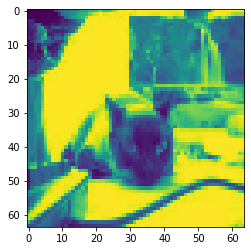

In [38]:
plt.imshow(train_64_64_1[5,:,:,0])

In [39]:
#normalize the data

X_train = train_64_64_1
X_test = test_64_64_1

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

#remove standardization scaling as it is good to make the input values between 0 and 1

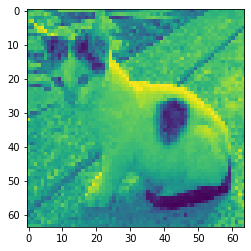

In [40]:
plt.imshow(X_train[3,:,:,0])

In [41]:
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
df_train['label_n'] = np.where(df_train['label']=='cat', 0, 1)

y_train = df_train['label_n'].to_numpy()
y_train


array([0, 0, 0, ..., 1, 1, 1])

In [42]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(X_train
                                                                              ,y_train
                                                                              ,test_size=.2
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [43]:
print(np.unique(y_train_split, return_counts=True))
print(np.unique(y_valid_split, return_counts=True))

(array([0, 1]), array([ 9985, 10015]))
(array([0, 1]), array([2515, 2485]))


In [44]:
print(x_train_split.shape)
print(x_valid_split.shape)
print(X_test.shape)

(20000, 64, 64, 1)
(5000, 64, 64, 1)
(12500, 64, 64, 1)


In [45]:
# define function for turning softmax result to class category
def class_output(result):
  pred_list = []
  for i in range(len(result)):
    pred = np.argmax(result[i])
    pred_list.append(pred)
  return np.array(pred_list).reshape((len(result), 1))

In [46]:
##initiate list to track performance for each model


train_accuracy = []
val_accuracy = []
test_accuracy = []
recall = []
f1 = []
precision = []
train_time = []

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [49]:
# define evaluation metrics tracking function

def score_track(model, x_train, y_train, x_val, y_val):
  result_dic = {}

  pred_trn = class_output(model.predict(x_train))
  ac_trn = accuracy_score(y_train, pred_trn)
  result_dic['accuracy_train'] = ac_trn

  pred_val = class_output(model.predict(x_val))
  ac_val = accuracy_score(y_val, pred_val)
  result_dic['accuracy_valid'] = ac_val
  f1_val = f1_score(y_val, pred_val, average = 'macro')
  result_dic['f1_val'] = f1_val
  recall_val = recall_score(y_val, pred_val, average = 'macro')
  result_dic['recall_val'] = recall_val
  precision_val = precision_score(y_val, pred_val, average = 'macro')
  result_dic['precision_val'] = precision_val

  #there is no test label dataset, since it is for competition

  return result_dic

#Experiment 11 - Semi-supervised Generative Adverserial Networks (GAN)



In [50]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot
from keras import backend

In [62]:
# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result
 
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(64,64,1), n_classes=2):
	# image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

In [64]:
# define the standalone generator model
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 16x16 image
	n_nodes = 128 * 16 * 16
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((16, 16, 128))(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (16,16), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

	#https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

In [65]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [66]:
# transform the raw data
def load_real_samples():
    X_train = train_64_64_1
    y = y_train
    X = X_train.astype('float32')
	  # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, y_train.shape)
    return [X, y]

In [67]:
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=1000, n_classes=2):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		# get all images for this class
		X_with_class = X[y == i]
		# choose random instances
		ix = randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list)

In [68]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [69]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

In [73]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [74]:
# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

(25000, 64, 64, 1) (25000,)
(1000, 64, 64, 1) (1000,)
n_epochs=20, n_batch=100, 1/2=50, b/e=250, steps=5000
>1, c[0.690,58], d[0.406,1.100], g[0.405]
>2, c[0.697,50], d[0.386,1.102], g[0.404]
>3, c[0.687,56], d[0.363,1.106], g[0.402]
>4, c[0.700,44], d[0.338,1.116], g[0.399]
>5, c[0.694,58], d[0.319,1.131], g[0.393]
>6, c[0.685,64], d[0.292,1.153], g[0.387]
>7, c[0.690,54], d[0.263,1.171], g[0.384]
>8, c[0.666,70], d[0.245,1.180], g[0.388]
>9, c[0.664,66], d[0.216,1.155], g[0.404]
>10, c[0.715,56], d[0.183,1.094], g[0.442]
>11, c[0.726,54], d[0.171,1.012], g[0.494]
>12, c[0.693,58], d[0.171,0.951], g[0.530]
>13, c[0.723,52], d[0.134,0.932], g[0.536]
>14, c[0.689,60], d[0.129,0.944], g[0.518]
>15, c[0.706,62], d[0.138,0.974], g[0.487]
>16, c[0.760,46], d[0.142,1.003], g[0.466]
>17, c[0.757,50], d[0.079,1.039], g[0.455]
>18, c[0.825,40], d[0.048,1.134], g[0.440]
>19, c[0.774,52], d[0.117,1.284], g[0.397]
>20, c[0.662,64], d[0.066,1.497], g[0.362]
>21, c[0.681,60], d[0.053,1.492], g[0.362

In [2]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/458_AI/A4/Assignment4_part3_GAN.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/458_AI/A4/Assignment4_part3_GAN.ipynb to html
[NbConvertApp] Writing 1477509 bytes to /content/gdrive/MyDrive/458_AI/A4/Assignment4_part3_GAN.html
